# Word2Vec optimizaiton via K-Means hyperparameters search

**Objective**

The idea is to loop over the pre-trained Word2Vec models and then perform a grid search over different values of K, the number of clusters. 

The best Word2Vec parametrization will be the one that leads to best K-Means results.

## Spark Session 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("W2V_optimization").getOrCreate()
spark

CPU times: user 135 ms, sys: 61.2 ms, total: 196 ms
Wall time: 1min 14s


## Import data

**Read from csv file**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

errors = spark.read.json("sample_app_test_train_ATLAS.json").select(
    "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# visualize data
# errors.toPandas().head(10)

## Choose best Word2Vec hyperparameters

In [3]:
from matplotlib import pyplot as plt

plt.plot([],[])

<div class="alert alert-block alert-warning">
<b>Alert:</b> The cell above is just to enable plot visualization from here onwards as apparently they are not displayed the first time plt.plot() is called. I suspect there's a bug in jupyter/pyplot.
</div>

### Optimization 

<div class="alert alert-block alert-info">
<b>Note:</b> Results are saved into the specified <i>kmeans_log_base</i> folder. Currently, they need to be checked manually in order to pick the best hyperparameters configuration. Automation of this process will be considered in a refinement phase.
</div>

Training for vector_size=250, window_size=8 and min_count=100
Started at: 2020-03-24 11:23:09

Training for K=8
Started at: 2020-03-24 11:23:11


Time elapsed: 9 minutes and 28 seconds.
------------------------------------------------------------
Training for K=12
Started at: 2020-03-24 11:32:40


Time elapsed: 10 minutes and 5 seconds.
------------------------------------------------------------
Training for K=16
Started at: 2020-03-24 11:42:45


Time elapsed: 9 minutes and 13 seconds.
------------------------------------------------------------
Training for K=20
Started at: 2020-03-24 11:51:59


Time elapsed: 12 minutes and 21 seconds.
------------------------------------------------------------
The best K according to the WSSE is 20
The best K according to the SILHOUETTE is 20


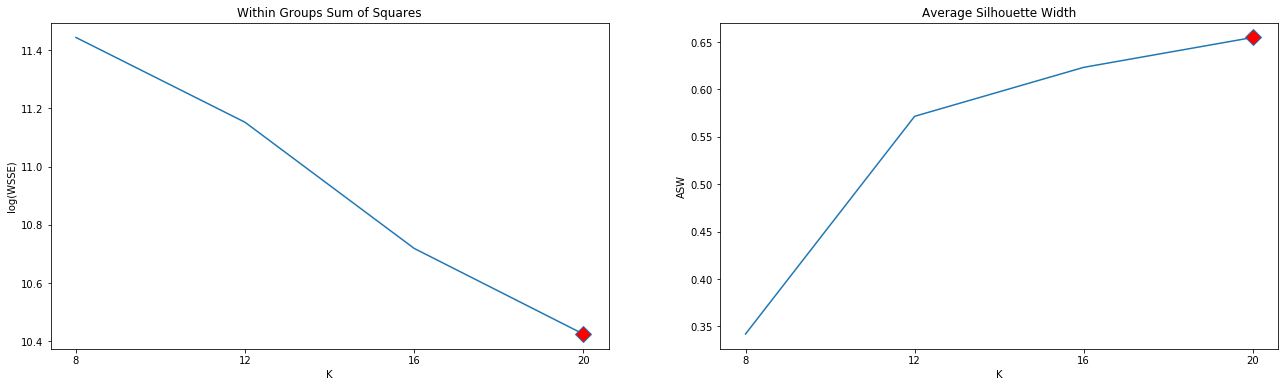


Time elapsed: 41 minutes and 11 seconds.
------------------------------------------------------------
Training for vector_size=250, window_size=8 and min_count=500
Started at: 2020-03-24 12:04:21

Training for K=8
Started at: 2020-03-24 12:04:22


Time elapsed: 9 minutes and 6 seconds.
------------------------------------------------------------
Training for K=12
Started at: 2020-03-24 12:13:29


Time elapsed: 9 minutes and 56 seconds.
------------------------------------------------------------
Training for K=16
Started at: 2020-03-24 12:23:26


Time elapsed: 10 minutes and 37 seconds.
------------------------------------------------------------
Training for K=20
Started at: 2020-03-24 12:34:03


Time elapsed: 16 minutes and 2 seconds.
------------------------------------------------------------
The best K according to the WSSE is 20
The best K according to the SILHOUETTE is 12


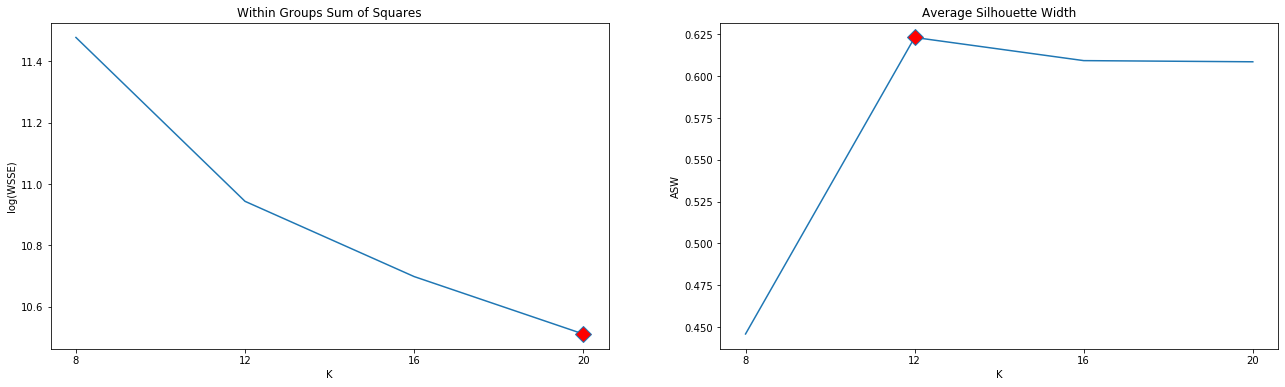


Time elapsed: 45 minutes and 44 seconds.
------------------------------------------------------------
CPU times: user 7.33 s, sys: 2.17 s, total: 9.5 s
Wall time: 1h 26min 56s


In [6]:
%%time

import time, datetime
from language_models import load_w2v
from kmeans import get_k_best, plot_metrics
from language_models import tokenizer
import kmeans
import importlib
importlib.reload(kmeans)

vs_list = [100,150,200,250]
mc_list = [100, 500]
ws_list = [8]


# setup w2v model paths
train_day = "2020-03-19"
data_window = "9-13mar2020"
w2v_path = "results/sample_app/w2v_models/data_window_{}/train_date_{}".format(data_window, train_day)

# setup kmeans log base path
kmeans_log_base = "results/sample_app/kmeans_models/inference"

# initialise list of values of K
k_list = [8, 12, 16, 20]

for vs in vs_list:
    for mc in mc_list:
        for ws in ws_list:
            
            start_time = time.time()
            start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
            print("Training for vector_size={}, window_size={} and min_count={}".format(vs, ws, mc))
            print("Started at: {}\n".format(start_time_string))
            
            # load saved model
#             w2v_model = load_w2v("{}/w2v_sample_app_example_VS={}_MC={}".format(w2v_path, vs, mc))
            w2v_model = load_w2v("{}/w2v_sample_app_example_VS={}_MC={}_WS={}".format(w2v_path, vs, mc, ws))
            err_tks = tokenizer(errors, err_col="t__error_message", id_col="msg_id")

            # get the vector representation of messages
            err_tks = w2v_model.transform(err_tks)
            
            n_cores = 1
            kmeans_log = """{}/kmeans_optimization_log_VS={}_MC={}_WS={}_cores={}.txt""".format(
                kmeans_log_base, vs, mc, ws, n_cores)

            # train for different Ks
            res = kmeans.K_optim(k_list, dataset=err_tks, tks_vec="message_vector", ft_col="features", 
                                 n_cores=n_cores, distance="cosine", initSteps=30, tol=0.001, maxIter=30,
                                 log_path=kmeans_log)

            # extract the best K according to within-cluster sum of squared distances (WSSE)
            k_wsse = get_k_best(res, "wsse")
            # extract the best K according to average silhouette value (ASW)
            k_sil = get_k_best(res, "silhouette")

            print("The best K according to the WSSE is {}".format(k_wsse))
            print("The best K according to the SILHOUETTE is {}".format(k_sil))

            # plot WSSE and ASW trends as a function of K 
            # (WARNING: you ay need to run two times the cell to get the plot)
            plot_metrics(res)
            
            print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60), 
                                                                      int((time.time() - start_time)%60)))
            print('--'*30)            